In [2]:
import os

In [ ]:
# !cp -r hand-data resized-hand-data

# Get Path to All Images and Annotations

In [4]:
all_files = ["./hand-data/{}".format(f) for f in os.listdir('./hand-data')]
all_images = [f for f in all_files if ".jpg" in f]
all_text = [f for f in all_files if ".txt" in f]

## Find all the images without annotations

In [12]:
images_missing_annotation = list(set([f.replace(".jpg", "") for f in all_images]) - set([f.replace(".txt", "") for f in all_text]))
len(images_missing_annotation)

10858

## Remove unannotated images

In [15]:
for image in images_missing_annotation:
    os.remove(image + ".jpg")

In [16]:
len(all_images), len(all_text)

(20517, 9661)

## Resize Images to 64x64, make grayscale

In [42]:
!cp -r hand-data small-hands

In [43]:
!cd small-hands && mogrify -resize 64x64\! *.jpg

In [44]:
!cp -r small-hands small-gray-hands

In [45]:
!cd small-gray-hands && mogrify -type Grayscale *.jpg

## Load Image as Numpy Matrix

In [46]:
import numpy as np
from scipy import misc

In [56]:
from matplotlib import pyplot as plt
from matplotlib import patches

In [52]:
im = misc.imread("./small-gray-hands/VID_20190111_181640.mp4_frame014.jpg")
im.shape

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


(64, 64)

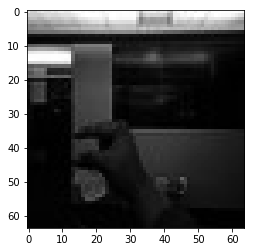

In [55]:
plt.imshow(im, cmap='gray')

## Parse our YOLO Annotation

In [60]:
annotation = open("./small-gray-hands/VID_20190111_181640.mp4_frame014.txt").read()
annotation

'0 0.36319444444444443 0.6791666666666667 0.3236111111111111 0.3625'

In [61]:
[xcenter,ycenter,w,h] = [float(f) for f in annotation.split(" ")[1:]]

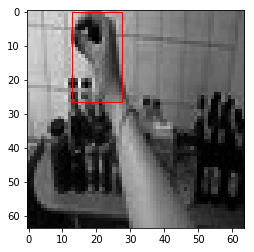

In [106]:
fig,ax = plt.subplots(1)
ax.imshow(im, cmap='gray')

ax.add_patch(
    patches.Rectangle((xcenter * 64 - w * 32, ycenter*64 - h*32),w*64,h*64,linewidth=1,edgecolor='r',facecolor='none')
)

plt.show()

## Create "Solution" Image

In [ ]:
sol_sz = (20,20)

In [ ]:
sol_image = np.zeros(sol_sz)
for y in range(sol_image.shape[0]):
    for x in range(sol_image.shape[1]):
        xp = (x + 0.5) / sol_image.shape[1]
        yp = (y + 0.5) / sol_image.shape[0]
        
        if abs(xp - xcenter) < w / 2 and abs(yp - ycenter) < h / 2:
            sol_image[y,x] = 1
plt.imshow(sol_image, cmap="gray")

In [109]:
def get_sol_im(xcenter,ycenter,w,h):
    sol_image = np.zeros(sol_sz)
    for y in range(sol_image.shape[0]):
        for x in range(sol_image.shape[1]):
            xp = (x + 0.5) / sol_image.shape[1]
            yp = (y + 0.5) / sol_image.shape[0]

            if abs(xp - xcenter) < w / 2 and abs(yp - ycenter) < h / 2:
                sol_image[y,x] = 1
    return sol_image

## Put it all together into matrices

In [110]:
from tqdm import tqdm_notebook as tqdm

In [111]:
prepped_files = [["./small-gray-hands/" + f, "./small-gray-hands/" + f.replace("txt", "jpg")] for f in os.listdir("./small-gray-hands") if ".txt" in f]
# make sure each pair exists
prepped_files = [[annotation_file, image_file] for annotation_file, image_file in prepped_files if os.path.isfile(annotation_file) and os.path.isfile(image_file)]

In [112]:
N = len(prepped_files)
N

9659

In [113]:
X = np.zeros((N, 64, 64))
Y = np.zeros((N, sol_sz[0], sol_sz[1]))
for i, (annotation_file, image_file) in tqdm(enumerate(prepped_files)):
    im = misc.imread(image_file)
    [xcenter,ycenter,w,h] = [float(f) for f in open(annotation_file).read().split(" ")[1:]]
    sol_im = get_sol_im(xcenter,ycenter,w,h)
    X[i, :, :] = im
    Y[i, :, :] = sol_im

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


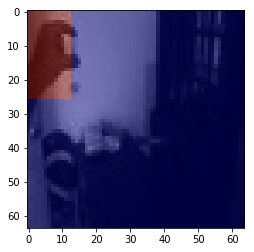

In [114]:
plt.imshow(X[500], cmap="gray")
plt.imshow(misc.imresize(Y[500], (64,64), interp="nearest"), alpha=0.5, cmap="jet")
plt.show()

## Place Matrices into Files

In [115]:
np.save("x.npy", X)
np.save("y.npy", Y)